## Autoencoders

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# loading and preprocessing the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # [-1, 1]
])

train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 229kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 4.22MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.59MB/s]


In [ ]:
# Defining Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.encoder(x)
        x = self.decoder(x)
        return x.view(-1, 1, 28, 28)

# Training function
def train_ae(latent_dim, num_epochs=20):
    model = Autoencoder(latent_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for img, _ in train_loader:
            img = img.to(device)
            optimizer.zero_grad()
            output = model(img)
            loss = criterion(output, img)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * img.size(0)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_dataset):.4f}')
    return model

# Training both models
model_16 = train_ae(16)
model_48 = train_ae(48)

Epoch [1/20], Loss: 0.0769
Epoch [2/20], Loss: 0.0531
Epoch [3/20], Loss: 0.0498
Epoch [4/20], Loss: 0.0480
Epoch [5/20], Loss: 0.0468
Epoch [6/20], Loss: 0.0458
Epoch [7/20], Loss: 0.0451
Epoch [8/20], Loss: 0.0446
Epoch [9/20], Loss: 0.0441
Epoch [10/20], Loss: 0.0437
Epoch [11/20], Loss: 0.0433
Epoch [12/20], Loss: 0.0430
Epoch [13/20], Loss: 0.0428
Epoch [14/20], Loss: 0.0426
Epoch [15/20], Loss: 0.0423
Epoch [16/20], Loss: 0.0422
Epoch [17/20], Loss: 0.0420
Epoch [18/20], Loss: 0.0419
Epoch [19/20], Loss: 0.0417
Epoch [20/20], Loss: 0.0416
Epoch [1/20], Loss: 0.0694
Epoch [2/20], Loss: 0.0415
Epoch [3/20], Loss: 0.0371
Epoch [4/20], Loss: 0.0350
Epoch [5/20], Loss: 0.0336
Epoch [6/20], Loss: 0.0327
Epoch [7/20], Loss: 0.0320
Epoch [8/20], Loss: 0.0314
Epoch [9/20], Loss: 0.0309
Epoch [10/20], Loss: 0.0306
Epoch [11/20], Loss: 0.0302
Epoch [12/20], Loss: 0.0299
Epoch [13/20], Loss: 0.0297
Epoch [14/20], Loss: 0.0294
Epoch [15/20], Loss: 0.0293
Epoch [16/20], Loss: 0.0290
Epoch [17/

In [ ]:
# Evaluating the models
def evaluate(model, loader):
    model.eval()
    total_loss = 0
    criterion = nn.MSELoss()
    with torch.no_grad():
        for img, _ in loader:
            img = img.to(device)
            output = model(img)
            total_loss += criterion(output, img).item() * img.size(0)
    return total_loss / len(loader.dataset)

print('Model 16:')
print(f'Train MSE: {evaluate(model_16, train_loader):.4f}')
print(f'Test MSE: {evaluate(model_16, test_loader):.4f}\n')

print('Model 48:')
print(f'Train MSE: {evaluate(model_48, train_loader):.4f}')
print(f'Test MSE: {evaluate(model_48, test_loader):.4f}')

Model 16:
Train MSE: 0.0414
Test MSE: 0.0432

Model 48:
Train MSE: 0.0283
Test MSE: 0.0295


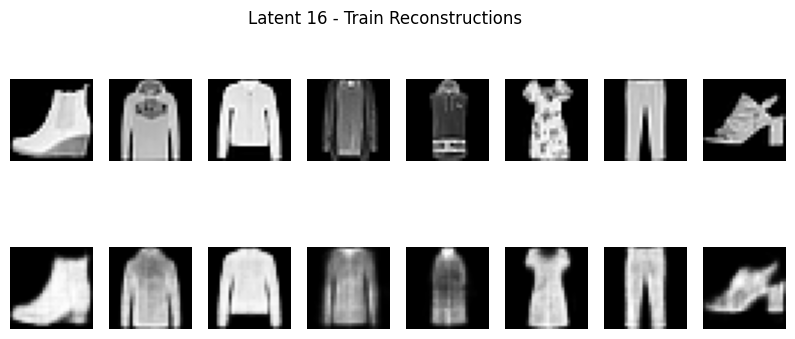

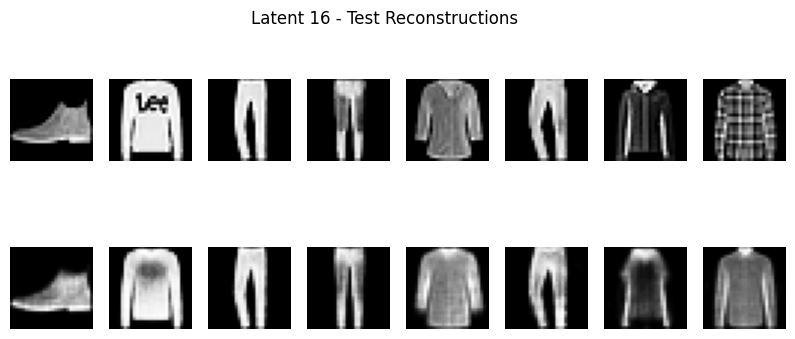

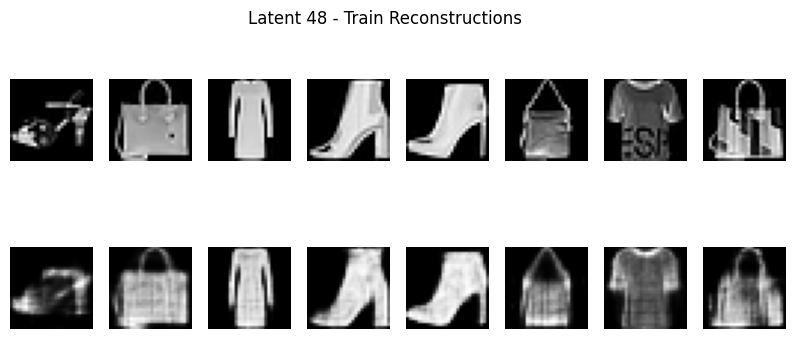

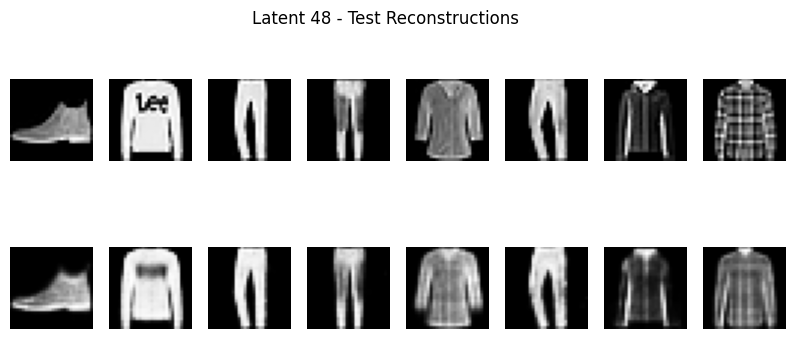

In [ ]:
# Visualizing reconstructions
def show_reconstructions(model, loader, title):
    data, _ = next(iter(loader))
    data = data[:8].to(device)
    with torch.no_grad():
        recon = model(data).cpu()

    plt.figure(figsize=(10, 4))
    for i in range(8):
        # Original
        plt.subplot(2, 8, i+1)
        plt.imshow(data[i].cpu().squeeze().numpy()*0.5+0.5, cmap='gray')
        plt.axis('off')
        # Reconstructed
        plt.subplot(2, 8, i+9)
        plt.imshow(recon[i].squeeze().numpy()*0.5+0.5, cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Show results for both models
show_reconstructions(model_16, train_loader, 'Latent 16 - Train Reconstructions')
show_reconstructions(model_16, test_loader, 'Latent 16 - Test Reconstructions')
show_reconstructions(model_48, train_loader, 'Latent 48 - Train Reconstructions')
show_reconstructions(model_48, test_loader, 'Latent 48 - Test Reconstructions')

Latent‑16 Interpolations:


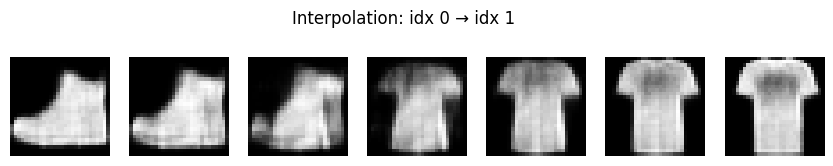

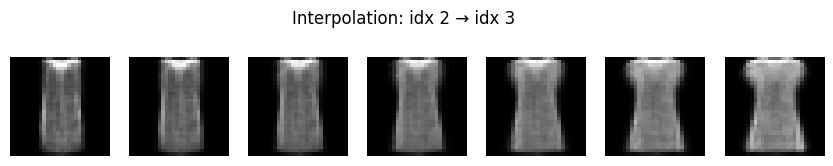

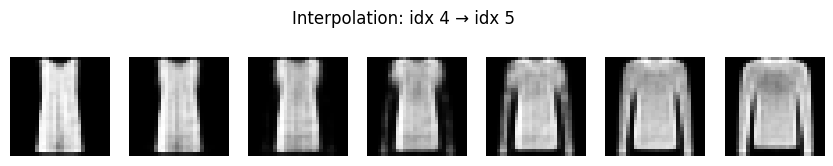

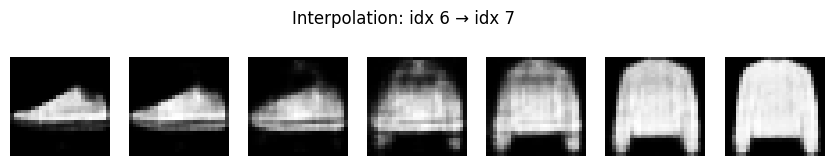


Latent‑48 Interpolations:


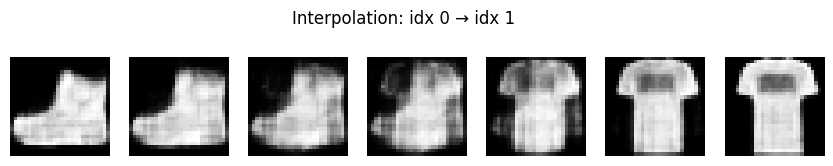

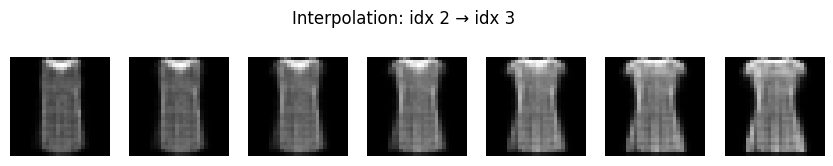

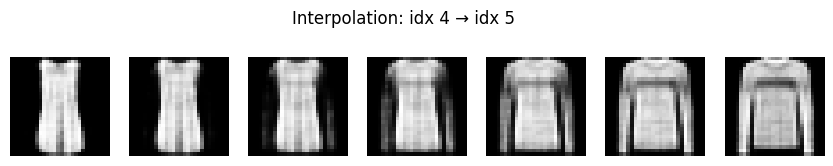

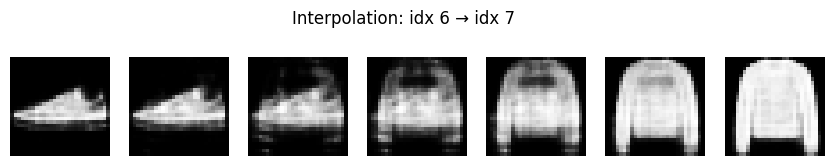

In [ ]:
def interpolate(model, dataset, idx1, idx2, num_steps=7):
    # grab and flatten the two images
    img1 = dataset[idx1][0].unsqueeze(0).to(device)
    img2 = dataset[idx2][0].unsqueeze(0).to(device)

    # encode to latent vectors
    with torch.no_grad():
        z1 = model.encoder(img1.view(1, -1))
        z2 = model.encoder(img2.view(1, -1))

    # generate interpolation coefficients
    alphas = torch.linspace(0, 1, num_steps)

    decoded = []
    for α in alphas:
        z = (1 - α) * z1 + α * z2
        recon = model.decoder(z)
        # reshape to (1,1,28,28)
        recon = recon.view(1, 1, 28, 28)
        # remove both singleton dims to get (28,28)
        recon = recon.squeeze().cpu().detach()
        decoded.append(recon)

    # plot trajectory
    plt.figure(figsize=(num_steps * 1.5, 2))
    for i, img in enumerate(decoded):
        arr = img.numpy() * 0.5 + 0.5
        plt.subplot(1, num_steps, i + 1)
        plt.imshow(arr, cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Interpolation: idx {idx1} → idx {idx2}', fontsize=12)
    plt.show()


# Now call it for your 4 pairs:
pairs = [(0, 1), (2, 3), (4, 5), (6, 7)]

print("Latent‑16 Interpolations:")
for i, j in pairs:
    interpolate(model_16, train_dataset, i, j, num_steps=7)

print("\nLatent‑48 Interpolations:")
for i, j in pairs:
    interpolate(model_48, train_dataset, i, j, num_steps=7)


## Key Observations:

Reconstruction quality - 48 dimensional latent space produces better reconstructions and lower MSE.

16 dimensional model shows blur reconstructions when compared to 48 dimensional model

Interpolation results - 48 dimension interpolations appear more natural and preserve details

transitions in 16 dimension space might show more abrupt changes